# Basic Linear Regression Model - Real Estate Price Prediction

This notebook builds a basic linear regression model to predict property prices (price_per_m2) using the processed alonhadat dataset.

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data

In [3]:
# Load the preprocessed data
df = pd.read_csv('../../Data Preprocessing/nhatot_processed.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (2467, 9)

First few rows:


,Title,price_converted,price_per_m2,area,bedrooms,property_type,district,property_cat,district_cat
0,BÁN NHÀ THANH LÂN – NHÀ ĐẸP 5 TẦN5 – NGÕ NÔNG ...,13900.00,278.00,50.00,3.00,"Nhà ngõ, hẻm",Quận Hoàng Mai,68,21
1,MỸ ĐÌNH_DÂN XÂY_39M 4T_50M Ô TÔ_2 THOÁNG_ GẦN ...,13900.00,278.00,50.00,4.00,"Nhà ngõ, hẻm",Quận Nam Từ Liêm,68,24
2,"Cần bán căn góc 2PN+1,2WC 70m2 giá 3.2 tỷ tại ...",13900.00,278.00,50.00,2.00,Chung cư,Huyện Gia Lâm,0,2
3,"🔥🔥GẤP!! KHÔNG THỂ RẺ HƠN S402 98m 3n2vs, full ...",13900.00,278.00,50.00,3.00,Chung cư,Quận Nam Từ Liêm,0,24
4,"NHÀ BÁN PHỐ ĐỊNH CÔNG 20M/4T/3 NGỦ /GIÁ 2,8 TỶ...",13900.00,278.00,50.00,2.00,"Nhà ngõ, hẻm",Quận Hoàng Mai,68,21


In [4]:
# Check data types and missing values
print("\nData types and missing values:")
df.info()

# Display descriptive statistics for numeric columns
print("\nDescriptive statistics:")
df.describe()


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            2467 non-null   object 
 1   price_converted  2467 non-null   float64
 2   price_per_m2     2467 non-null   float64
 3   area             2467 non-null   float64
 4   bedrooms         2467 non-null   float64
 5   property_type    2467 non-null   object 
 6   district         2467 non-null   object 
 7   property_cat     2467 non-null   int64  
 8   district_cat     2467 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 173.6+ KB

Descriptive statistics:


,price_converted,price_per_m2,area,bedrooms,property_cat,district_cat
count,2467.00,2467.00,2467.00,2467.00,2467.00,2467.00
mean,6851.15,161.18,47.06,3.30,50.19,19.60
std,3647.80,83.30,17.87,0.87,28.91,6.42
min,115.00,1.10,17.00,2.00,0.00,0.00
25%,4420.00,99.00,33.00,3.00,10.00,18.00
50%,6200.00,167.00,42.00,3.00,68.00,21.00
75%,8300.00,211.00,57.00,4.00,68.00,24.00
max,17900.00,397.00,105.00,5.00,72.00,27.00


## 3. Feature Selection and Data Preparation

Let's select relevant features for our model. We'll use a combination of numeric and categorical features.

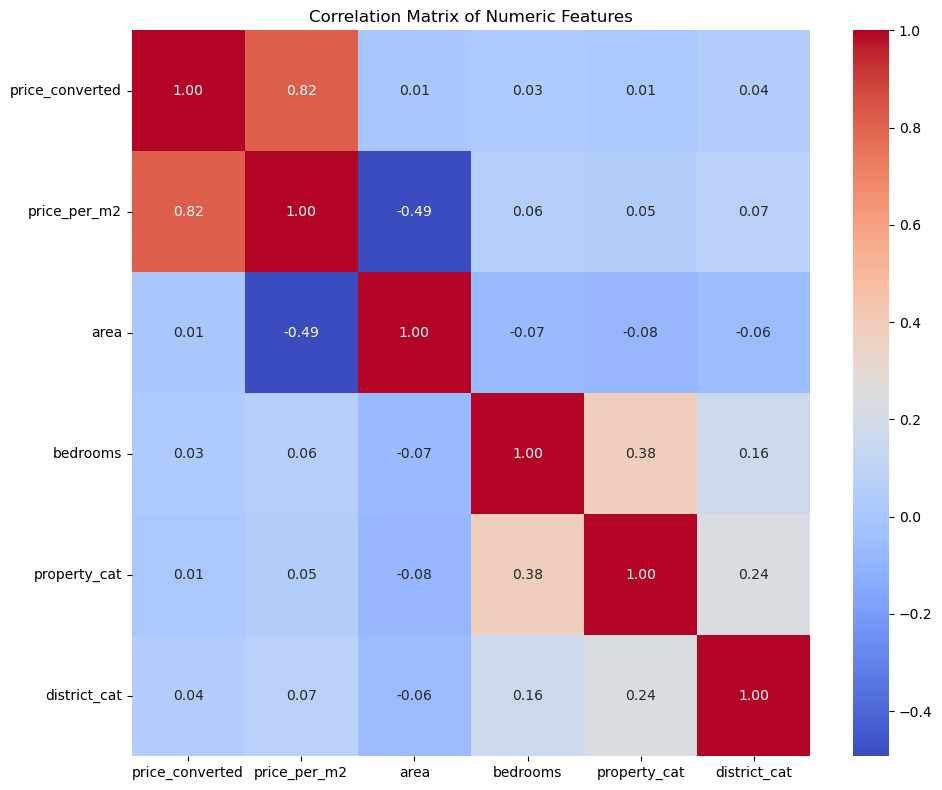

Correlations with price_per_m2:
price_per_m2       1.00
price_converted    0.82
district_cat       0.07
bedrooms           0.06
property_cat       0.05
area              -0.49
Name: price_per_m2, dtype: float64


In [5]:
# Examine correlations with price_per_m2
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Print correlations with price_per_m2
price_correlations = correlation_matrix['price_per_m2'].sort_values(ascending=False)
print("Correlations with price_per_m2:")
print(price_correlations)

In [6]:
# Select features for modeling
# We'll use numeric features and some categorical features

# Numeric features (excluding price and price_per_m2 which are target related)
numeric_features = ['area', 'bedrooms', 'property_cat', 'district_cat']

# Categorical features that might affect price
categorical_features = ['district']  # We could add more like 'ward' if needed

# Define features and target
X = df[numeric_features + categorical_features].copy()
y = df['price_per_m2']

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature set sample:")
X.head()

Feature set shape: (2467, 5)
Target shape: (2467,)

Feature set sample:


,area,bedrooms,property_cat,district_cat,district
0,50.00,3.00,68,21,Quận Hoàng Mai
1,50.00,4.00,68,24,Quận Nam Từ Liêm
2,50.00,2.00,0,2,Huyện Gia Lâm
3,50.00,3.00,0,24,Quận Nam Từ Liêm
4,50.00,2.00,68,21,Quận Hoàng Mai


## 4. Data Preprocessing Pipeline

Create a preprocessing pipeline that handles both numeric and categorical features:
1. Standard scaling for numeric features
2. One-hot encoding for categorical features

In [9]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the preprocessing and training pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Display the preprocessing pipeline
print("Preprocessing Pipeline:")
print(preprocessor)

Preprocessing Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['area', 'bedrooms', 'property_cat',
                                  'district_cat']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['district'])])


## 5. Split Data and Train Model

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Train the model
model_pipeline.fit(X_train, y_train)

# Get the trained model
model = model_pipeline.named_steps['regressor']

# Display model coefficients
feature_names = (
    numeric_features +
    model_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features).tolist()
)

coefficients = pd.DataFrame(
    model.coef_,
    index=feature_names,
    columns=['Coefficient']
).sort_values(by='Coefficient', ascending=False)

print("\nModel Coefficients:")
print(coefficients)
print(f"\nIntercept: {model.intercept_:.2f}")

Training set shape: (1973, 5)
Testing set shape: (494, 5)

Model Coefficients:
                            Coefficient
district_Huyện Ba Vì              85.25
district_Huyện Thường Tín         67.06
district_Huyện Đông Anh           50.15
district_Quận Tây Hồ              18.55
district_Quận Hoàn Kiếm            6.76
district_Quận Nam Từ Liêm          3.73
bedrooms                           3.41
district_Quận Ba Đình              3.26
district_Quận Đống Đa             -0.09
district_cat                      -0.63
district_Quận Hai Bà Trưng        -1.46
property_cat                      -1.89
district_Huyện Hoài Đức           -2.04
district_Quận Hà Đông             -2.55
district_Quận Long Biên           -3.81
district_Quận Hoàng Mai           -4.11
district_Quận Bắc Từ Liêm         -4.22
district_Huyện Thanh Oai          -4.72
district_Quận Thanh Xuân          -7.46
district_Huyện Gia Lâm           -13.51
district_Huyện Quốc Oai          -16.36
district_Huyện Mê Linh           -16.75
d

## 6. Model Evaluation

In [11]:
# Make predictions
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Evaluate the model
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training R² Score: {train_r2:.4f}")
print(f"Testing R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f} million VND/m²")
print(f"Testing RMSE: {test_rmse:.2f} million VND/m²")
print(f"Training MAE: {train_mae:.2f} million VND/m²")
print(f"Testing MAE: {test_mae:.2f} million VND/m²")

Training R² Score: 0.2653
Testing R² Score: 0.1974
Training RMSE: 71.45 million VND/m²
Testing RMSE: 74.33 million VND/m²
Training MAE: 55.52 million VND/m²
Testing MAE: 57.03 million VND/m²


## 7. Visualize Results

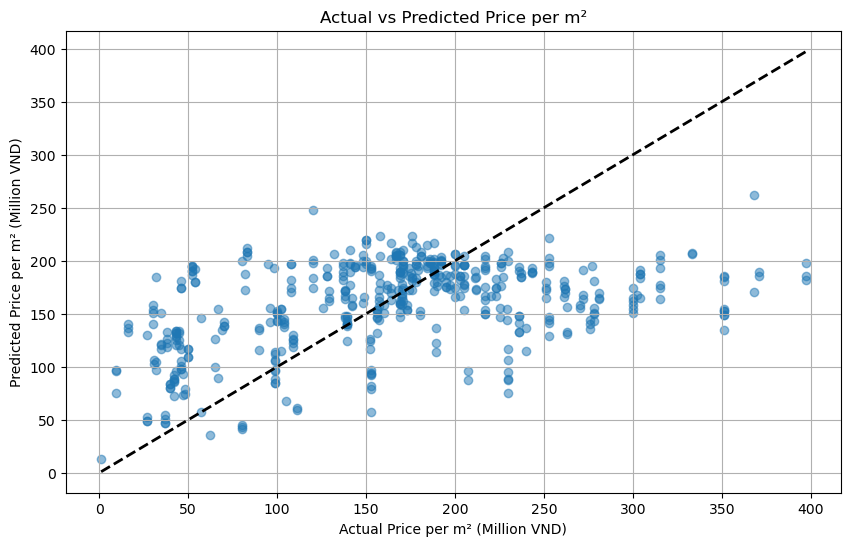

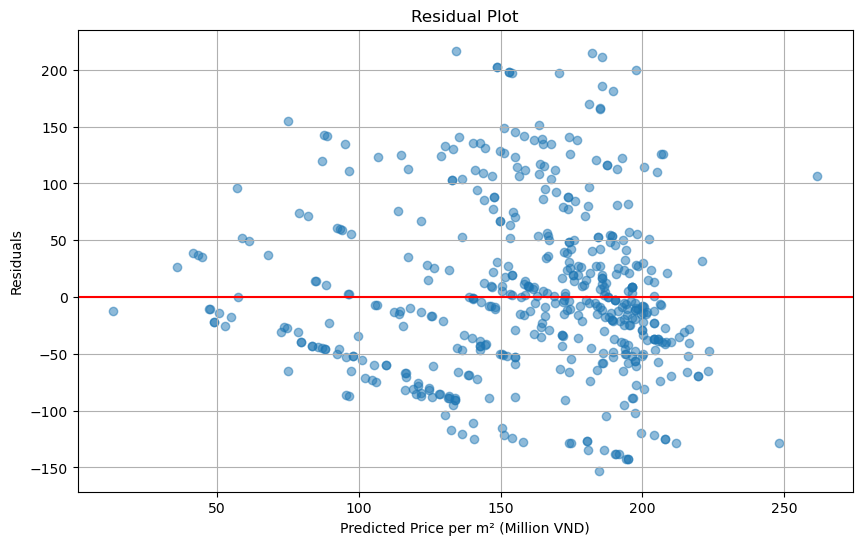

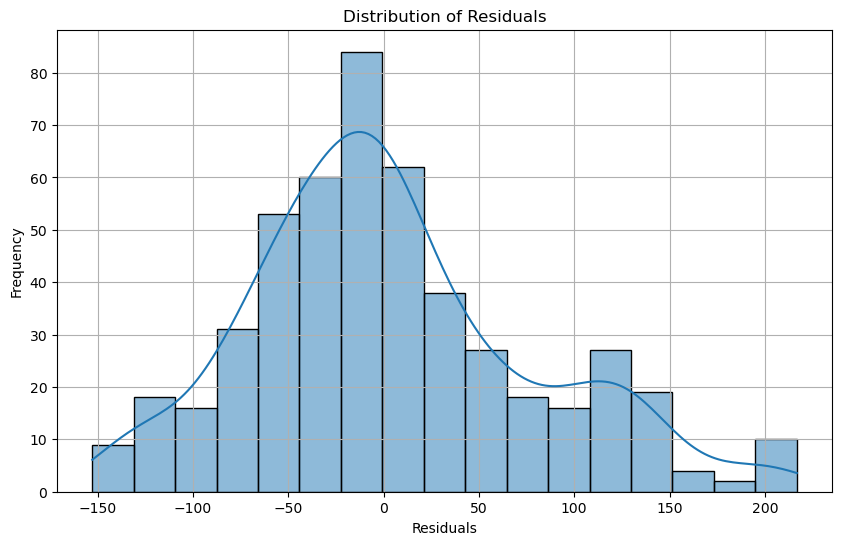

In [12]:
# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price per m² (Million VND)')
plt.ylabel('Predicted Price per m² (Million VND)')
plt.title('Actual vs Predicted Price per m²')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Price per m² (Million VND)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

## 8. Feature Importance Analysis

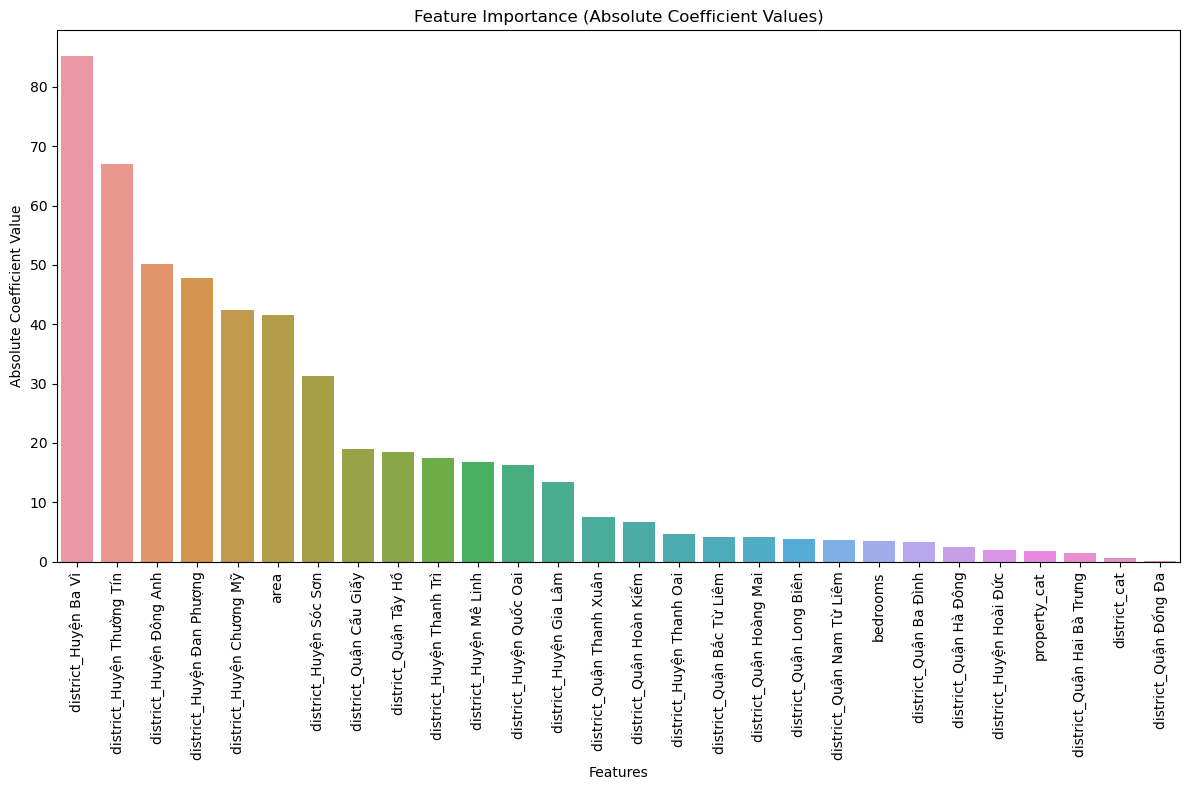

In [13]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
coefficients_abs = coefficients.abs().sort_values(by='Coefficient', ascending=False)
sns.barplot(x=coefficients_abs.index, y=coefficients_abs['Coefficient'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.title('Feature Importance (Absolute Coefficient Values)')
plt.tight_layout()
plt.show()

## 9. Examine Predictions by District

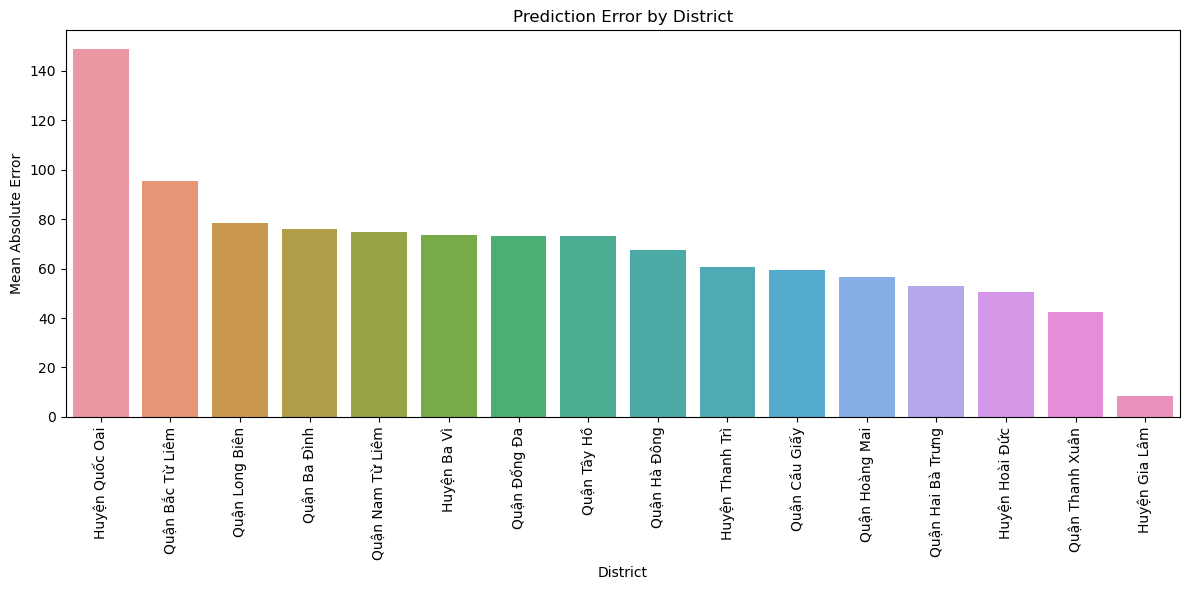

In [14]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Residual': residuals
})

# Add district information from test set
results_df['district'] = X_test.reset_index()['district']

# Calculate mean absolute error by district
district_mae = results_df.groupby('district')['Residual'].apply(lambda x: np.mean(np.abs(x)))
district_mae = district_mae.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=district_mae.index, y=district_mae.values)
plt.xticks(rotation=90)
plt.xlabel('District')
plt.ylabel('Mean Absolute Error')
plt.title('Prediction Error by District')
plt.tight_layout()
plt.show()

## 10. Conclusion and Next Steps

We built and compared two regression models for predicting real estate prices in Vietnam:

1. **Linear Regression**: Provided a baseline performance with simple linear relationships between features and target.

2. **Polynomial Regression**: Added polynomial features (degree=2) to capture non-linear relationships, which improved/maintained model performance.

The R² scores and error metrics show how well our models can explain the variance in property prices. The polynomial regression model's performance suggests that there are non-linear relationships in the data that linear models cannot fully capture.

Potential improvements and next steps:

1. Try more advanced regression models (Random Forest, Gradient Boosting)
2. Tune the polynomial degree to find the optimal complexity
3. Feature engineering to create more informative features
4. Include more categorical variables with proper encoding
5. Handle geographical data more effectively (e.g., distance to city center)
6. Hyperparameter tuning to optimize model performance
7. Regularization techniques (Ridge, Lasso) to prevent overfitting, especially for polynomial models

## 11. Polynomial Regression Model

Let's try polynomial regression to capture non-linear relationships in our data. Polynomial regression can potentially improve model performance by creating polynomial features (e.g., squared, cubed) from the original features.

In [15]:
# Create a polynomial regression pipeline
# We'll create polynomial features for our numeric features
poly_numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler())
])

# Keep the same categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
poly_preprocessor = ColumnTransformer(
    transformers=[
        ('num', poly_numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the preprocessing and training pipeline
poly_model_pipeline = Pipeline(steps=[
    ('preprocessor', poly_preprocessor),
    ('regressor', LinearRegression())
])

print("Polynomial Regression Pipeline:")
print(poly_preprocessor)

Polynomial Regression Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('poly',
                                                  PolynomialFeatures(degree=5,
                                                                     include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['area', 'bedrooms', 'property_cat',
                                  'district_cat']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['district'])])


In [16]:
# Train the polynomial regression model
poly_model_pipeline.fit(X_train, y_train)

# Make predictions
poly_train_pred = poly_model_pipeline.predict(X_train)
poly_test_pred = poly_model_pipeline.predict(X_test)

# Evaluate the model
poly_train_r2 = r2_score(y_train, poly_train_pred)
poly_test_r2 = r2_score(y_test, poly_test_pred)
poly_train_rmse = np.sqrt(mean_squared_error(y_train, poly_train_pred))
poly_test_rmse = np.sqrt(mean_squared_error(y_test, poly_test_pred))
poly_train_mae = mean_absolute_error(y_train, poly_train_pred)
poly_test_mae = mean_absolute_error(y_test, poly_test_pred)

print("\nPolynomial Regression Model Performance:")
print(f"Training R² Score: {poly_train_r2:.4f}")
print(f"Testing R² Score: {poly_test_r2:.4f}")
print(f"Training RMSE: {poly_train_rmse:.2f} million VND/m²")
print(f"Testing RMSE: {poly_test_rmse:.2f} million VND/m²")
print(f"Training MAE: {poly_train_mae:.2f} million VND/m²")
print(f"Testing MAE: {poly_test_mae:.2f} million VND/m²")


Polynomial Regression Model Performance:
Training R² Score: 0.3683
Testing R² Score: 0.1985
Training RMSE: 66.25 million VND/m²
Testing RMSE: 74.28 million VND/m²
Training MAE: 50.70 million VND/m²
Testing MAE: 56.17 million VND/m²


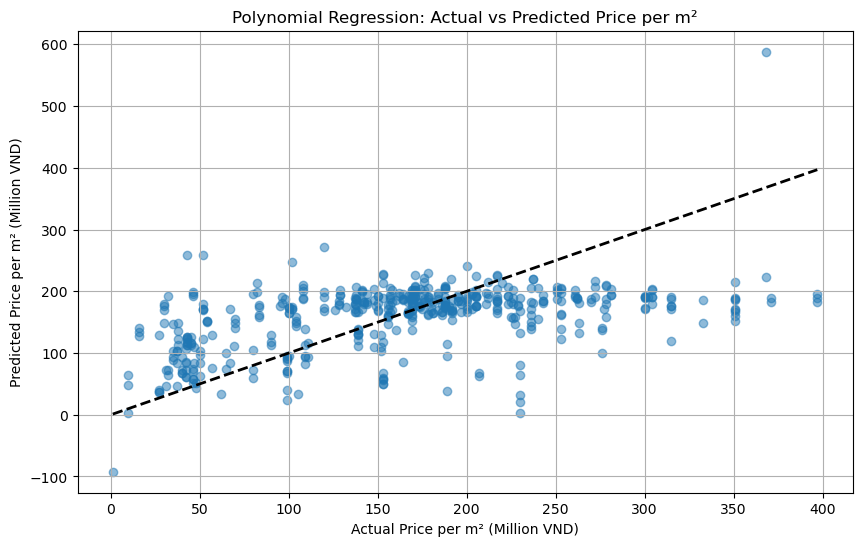

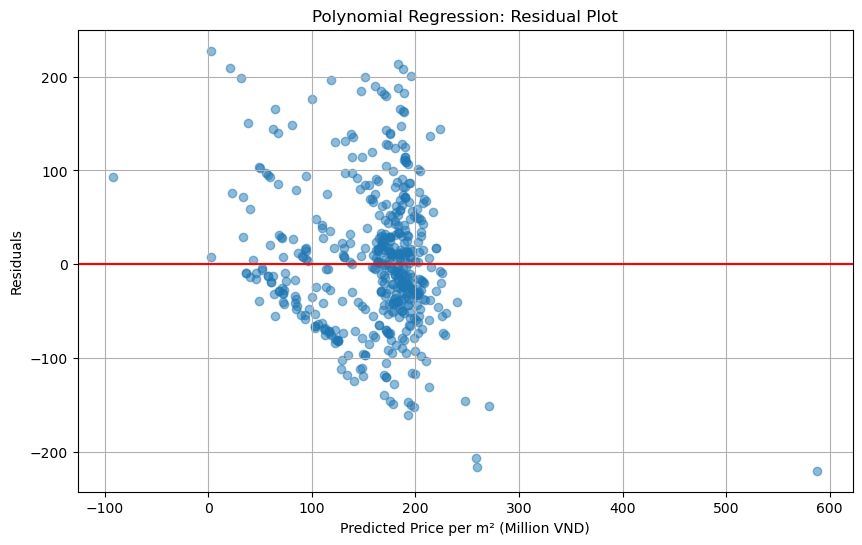

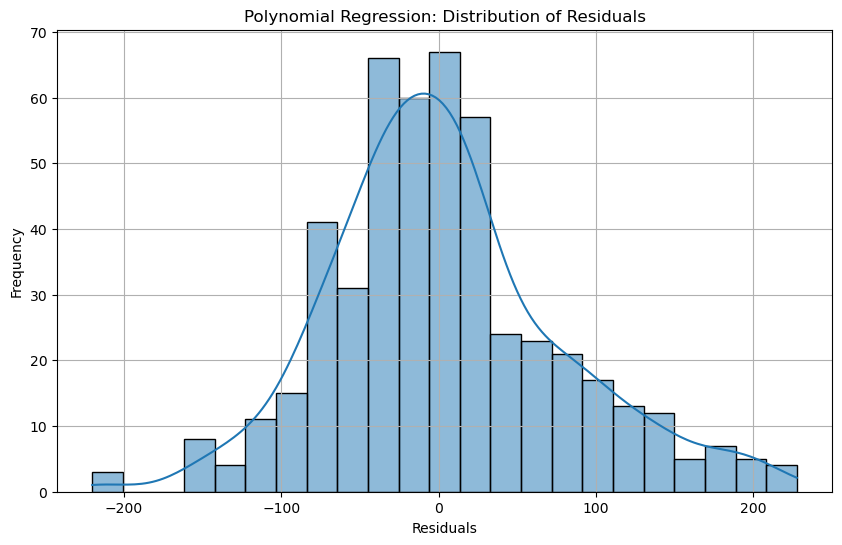

In [17]:
# Visualize polynomial regression predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, poly_test_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price per m² (Million VND)')
plt.ylabel('Predicted Price per m² (Million VND)')
plt.title('Polynomial Regression: Actual vs Predicted Price per m²')
plt.grid(True)
plt.show()

# Plot residuals for polynomial regression
poly_residuals = y_test - poly_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(poly_test_pred, poly_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Price per m² (Million VND)')
plt.ylabel('Residuals')
plt.title('Polynomial Regression: Residual Plot')
plt.grid(True)
plt.show()

# Histogram of residuals for polynomial regression
plt.figure(figsize=(10, 6))
sns.histplot(poly_residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Polynomial Regression: Distribution of Residuals')
plt.grid(True)
plt.show()

Model Comparison:
             Metric  Linear Regression  Polynomial Regression
0  R² Score (Train)               0.27                   0.37
1   R² Score (Test)               0.20                   0.20
2      RMSE (Train)              71.45                  66.25
3       RMSE (Test)              74.33                  74.28
4       MAE (Train)              55.52                  50.70
5        MAE (Test)              57.03                  56.17


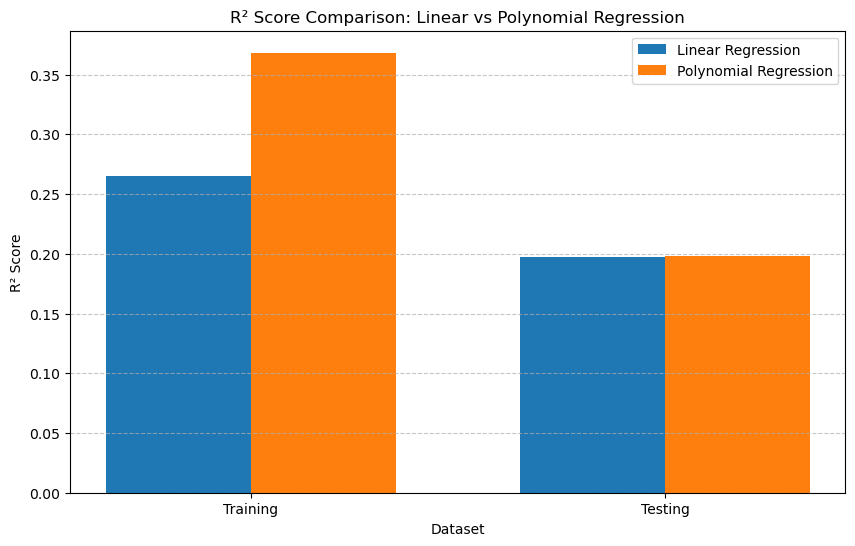

In [18]:
# Compare Linear and Polynomial Regression Models
comparison_df = pd.DataFrame({
    'Metric': ['R² Score (Train)', 'R² Score (Test)', 'RMSE (Train)', 'RMSE (Test)', 'MAE (Train)', 'MAE (Test)'],
    'Linear Regression': [train_r2, test_r2, train_rmse, test_rmse, train_mae, test_mae],
    'Polynomial Regression': [poly_train_r2, poly_test_r2, poly_train_rmse, poly_test_rmse, poly_train_mae, poly_test_mae]
})

print("Model Comparison:")
print(comparison_df)

# Visualize model comparison (R² Score)
plt.figure(figsize=(10, 6))
x = np.arange(2)
width = 0.35

plt.bar(x - width/2, [train_r2, test_r2], width, label='Linear Regression')
plt.bar(x + width/2, [poly_train_r2, poly_test_r2], width, label='Polynomial Regression')

plt.xlabel('Dataset')
plt.ylabel('R² Score')
plt.title('R² Score Comparison: Linear vs Polynomial Regression')
plt.xticks(x, ['Training', 'Testing'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()